# Обработка изображений

Компьютерное зрение - отрасль компьютерной науки, цель которой научить машины распознавать изображения.
Разпознавать - буквально извлекать знания из изображения.

В наше время компьютерное зрение находит широкое применение в безопасности - распознавание лиц и отпечатков пальцев, в промышленности - сортировка объектов на конвеерных линиях и пр.

Пример применения в ветеринарии - определение по отпечаткам лап давления в пятке {numref}`paws` для выявления травм и [анализа походки](https://todaysveterinarybusiness.com/wp-content/uploads/sites/4/2016/05/2016-0304_Rehab-Gait-Analysis.pdf).

::: {figure} paws

![](d/Kgt4H.png)

Автоматическое распознавание пальцев на отпечатках лапы.
:::

Рассмотрим более традиционное применение в биологии - подсчет колоний в чашке петри.

Современный алгоритм для решения этой задачи {cite}`geissmann2013` включает выделение фрагментов нормализованного изображения по порогу и выполнение дополнительных проверок {numref}`algopetri`.

::: {figure} algopetri
![](d/pone.0054072.g001.PNG_M.png)

Блок-схема, представляющая этапы обработки изображений.
(1) коррекция градуальных изменений интенсивности фона и повышение контрастности;
(2) генерация карты оценок путем итеративного аннотирования областей;
(3) поиск связанных компонентов в карте пороговых оценок и их сегментация;
(4) дополнительные фильтры.
:::

Рассмотрим некоторые шаги для понимания принципов работы с изображениями.

In [26]:
%pylab inline
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


## Загрузка изображения

Чтобы компьютер "видел" и считал, нужно получить цифровое изображение агарового слоя, например с помощью камеры, закрепленной над предметным столиком {numref}`petricamera`.

::: {figure} petricamera
![](d/pone.0033695.g001.PNG_I.png)

Установка для получения снимков содержимого чашек Петри 
[%copy; ](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0033695) 2012.
:::

Загрузим примеры изображений со страницы http://opencfu.sourceforge.net/samples.php


In [2]:
import zipfile
import os
import requests
from io import BytesIO

In [3]:
# скачаем архив
u = 'http://downloads.sourceforge.net/project/opencfu/samples/plosPicHQ.zip?r=http%3A%2F%2Fopencfu.sourceforge.net%2Fsamples.php&ts=1450794551&use_mirror=netcologne'
r = requests.get(u)
len(r.content)

5062054

Размер архива около 5Мб. Прочитаем и распакуем архив в текущей папке.

In [5]:
z = zipfile.ZipFile(BytesIO(r.content))
z.namelist()

['plosPicHQ/',
 'plosPicHQ/q120404-01.jpg',
 'plosPicHQ/q120404-02.jpg',
 'plosPicHQ/q120404-03.jpg',
 'plosPicHQ/q120404-04.jpg',
 'plosPicHQ/q120404-05.jpg',
 'plosPicHQ/q120404-06.jpg',
 'plosPicHQ/q120404-07.jpg',
 'plosPicHQ/q120404-08.jpg',
 'plosPicHQ/q120404-09.jpg',
 'plosPicHQ/q120404-10.jpg',
 'plosPicHQ/q120404-11.jpg',
 'plosPicHQ/q120404-12.jpg',
 'plosPicHQ/q120404-13.jpg',
 'plosPicHQ/q120404-14.jpg',
 'plosPicHQ/q120404-15.jpg',
 'plosPicHQ/q120404-16.jpg',
 'plosPicHQ/q120404-17.jpg',
 'plosPicHQ/q120404-18.jpg',
 'plosPicHQ/q120404-19.jpg']

In [6]:
z.extractall()
uu = z.namelist()

Загрузим первое из скачанных изображений. Для загрузки используем команду imread (от `image` read, "читать изображение"), а для просмотра `imshow` (от image show, "показывать изображение").

In [10]:
u1 = 'd/plosPicHQ/q120404-01.jpg'  # задаем путь к файлу с картинкой
I = imread(u1)
I.shape

(1536, 1538, 3)

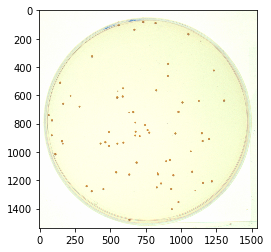

In [8]:
imshow(I);

Как следует из формы загруженного трехмерного массива чисел, изображение состоит из 2362368 точек, каждая из которых закодирована тремя числами (третье измерение).

## Анализ изображения

Как утверждают авторы - точки в чашке - это золотистый стафилококк [Staphylococcus aureus](https://ru.wikipedia.org/wiki/%D0%97%D0%BE%D0%BB%D0%BE%D1%82%D0%B8%D1%81%D1%82%D1%8B%D0%B9_%D1%81%D1%82%D0%B0%D1%84%D0%B8%D0%BB%D0%BE%D0%BA%D0%BE%D0%BA%D0%BA).

Изображение центрировано, и можно "обрезать" края чашки по координатам. Для надежности в реальном приложении нужно разработать специальный детектор края чашки. В крайнем случае, если стеклянный край светлее, чем колонии, то можно считать точки и за пределами чашки - ошибки не будет - ведь их там нет.

Возьмем для простоты прямоугольный фрагмент изображения.

In [11]:
F=I[800:1200, 810:1210]
F.shape

(400, 400, 3)

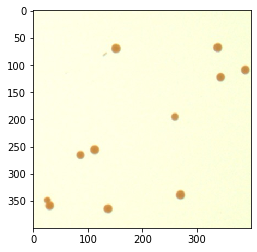

In [10]:
imshow(F);

Рассмотрим три цветовых канала (RGB), в которых закодирован цвет каждого точки (пикселя).
В большинстве форматов отсутствие цвета кодируется как 0, а полная насыщенность как максимальное значение - например, 255, если используется 8-битное кодирование с максимумом $2^8$.

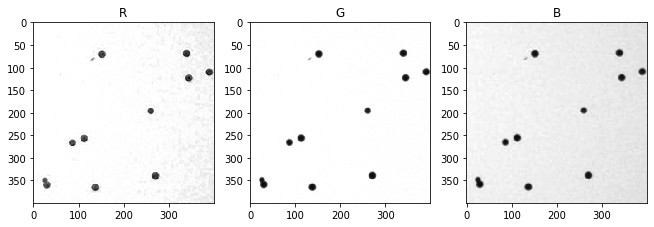

In [11]:
RGB='RGB'
figsize(11,4)
for i in range(F.shape[2]):
    subplot(1,F.shape[2], i+1)
    imshow(F[:,:,i], cmap='gray'); title(RGB[i])

Самый чистый и четкий - второй канал (зеленый). Будем использовать его.

> Подумайте, почему самый темный фон у синего канала? Как это связано с тем, что цвет агара на фотографии желтоватого цвета?

Инвертируем второй канал (с индексом 1), чтобы нужные значения были выше фона.  Если колонии белые на агаре с кровью, то, соответственно, инвертировать не нужно.

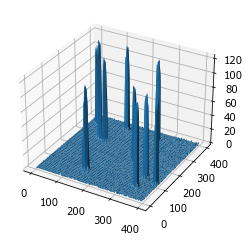

In [21]:
Z = 255 - F[:,:,1]

#отобразим значения в матрице Z в виде поверхности
from mpl_toolkits.mplot3d import Axes3D

fig = figure()
ax = fig.add_subplot(111, projection='3d')
X,Y = meshgrid(arange(Z.shape[1]), arange(Z.shape[0]))
ax.plot_surface(X,Y,Z);

В цифровом виде участки где выросли бактерии имеют более высокие значения, чем фон. Чтобы найти области, занятые бактериями, достаточно задать пороговое значение.

Для отображения границ одинаковой высоты удобно использовать контур.

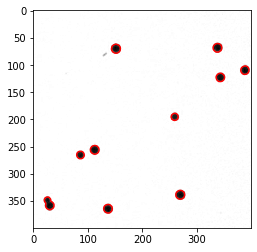

In [13]:
imshow(Z, cmap='gray_r');
coco = contour(Z, [Z.max()/2], colors='r')  # красная линия

In [14]:
n = len(coco.allsegs[0])
n

10

Итак, найдено 10 сегментов контурной линии. Каждый сегмент окружает колонию, то есть ответ готов. Можно усовершенствовать алгоритм для обнаружения некруглых объектов (как в левом нижнем углу фрагмента).

Для этого можно перебрать все найденные контуры и проверить их свойства (размер, форму).

In [15]:
n_dubli=0
for co in (coco.allsegs[0]):
    ss=co.max(0)-co.min(0)
    r = ss[0]/ss[1]
    
    # наивная проверка на круглость по отношению ширины и высоты сегмента
    if (r < 0.8) or (r > 1.2):
        vertex = co.min(0) + ss/2
        print('Подозрительно бесформенная колония размером {:.0f}x{:.0f} в ({:.0f},{:.0f})'.format(ss[0],ss[1], vertex[0], vertex[1]))
        
        # если не круглая - значит прибавляем еще одну колонию
        n_dubli+=1
    
n + n_dubli

Подозрительно бесформенная колония размером 18x23 в (29,355)


11

## Продвинутый анализ изображений

Мы рассмотрели простой случай, где колонии достаточно обособлены. В других случаях важно считать не количество, а площадь, занимаемую колониями. Если объекты разных типов, то нужно "научить" программу различать эти типы и считать их отдельно. 
[Примеры интерфейсов программ для полуавтоматического распознования разных клеток](http://ilastik.org/gallery.html).

Если много шума то нужно предварительно подготовить изображение, чтобы не выявлять мелкие частицы. 
Эти и другие процедуры берут на входе двухмерный массив и возвращают также двухмерный массив - в результате можно построить цепочку обработок.

Чтобы получить номера сегментов в виде изображения используем специальную библиотеку для работы с изображениями. Сначала сделаем сглаживание, затем каждой колонии зададим свой цвет, чтобы отличать их друг от друга и от фона.

In [16]:
import skimage.color
import skimage.filters
import skimage.measure

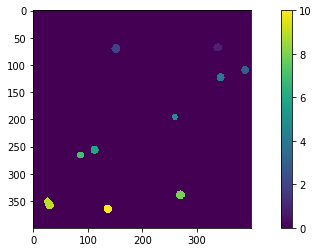

In [17]:
# сглаживаем двухмерным фильтром
Zf = skimage.filters.gaussian(Z, 4)

# размечаем на сегменты превышающие порог
porog = Zf.max()/2  # зададим порог вполовину от высоты "столбиков"
labeled = skimage.measure.label(Zf > porog)
imshow(labeled); colorbar();

Есть способ представить контуры в виде изображения.

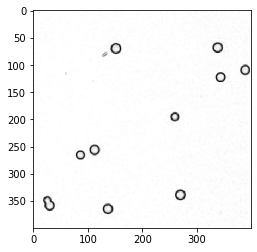

In [18]:
sob = skimage.filters.prewitt(Z)
imshow(sob, cmap='gray_r');

Если разметить отдельные сегменты уже на этом изображении, то получим разноцветные кольца.

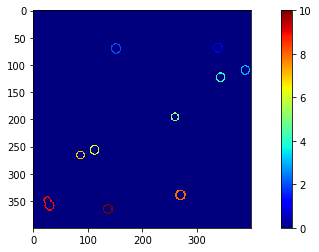

In [19]:
labeled = skimage.measure.label(sob > sob.max()*0.6)
imshow(labeled, cmap=cm.jet); colorbar();

Другая проблема - блики на прозрачных колониях. Получаются пиксели с несколькими уровнями яркости и надо тщательно подбирать уровень контурной обводки.

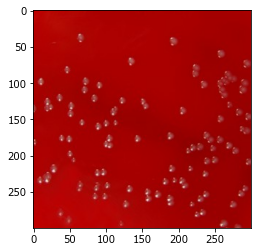

In [22]:
u1='d/plosPicHQ/neisseria_gonorrhoeae.jpg'
I=imread(u1)
F=I[100:400, 100:400]
imshow(F);

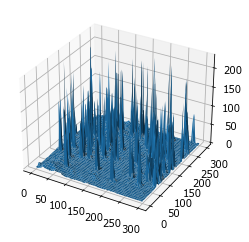

In [23]:
Z = F[:,:,1]  # инверсия не нужна

ax = figure().add_subplot(111, projection='3d')
X,Y = meshgrid(arange(Z.shape[1]), arange(Z.shape[0]))
ax.plot_surface(X,Y,Z);

Блики на 3D-картинке выглядят как острые пики.

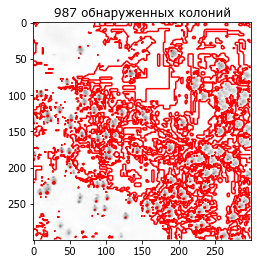

In [24]:
imshow(Z, cmap='gray_r'); 
coco=contour(Z, 1, colors='r') 
n=len(coco.allsegs[0])
title('{} обнаруженных колоний'.format(n));

С 1 контуром по-умолчанию уровень порога неудачный. Удобно подобрать порог интерактивно.

In [27]:
@interact(level=(0,255))
def _scale(level=25):
    imshow(Z, cmap='gray_r'); 
    coco=contour(Z, [level], colors='r')
    n=len(coco.allsegs[0])
    title('{} обнаруженных колоний'.format(n));

interactive(children=(IntSlider(value=25, description='level', max=255), Output()), _dom_classes=('widget-inte…

На уровне 25 получается правдоподобное число.

Проблему смежных колоний это конечно не решает, и нужно или делить площадь контура на среднюю площадь колонии или оценивать отклонение формы от круглой, как это было показано в исходном рецепте.

## * * *

Таким образом, лучший алгоритм обработки изображений - специально предназначенный для ваших данных.

Для начала следует попробовать готовые решения (особенно если они бесплатны).

Затем пробовать применить частично готовое - частично свое, сравнивая эффективность разных комбинаций методов на предварительно подготовленных изображениях {numref}`watershed`.

Впоследствие можно сделать свое решение, в виде компиляции известных методов, но подогнанных именно к вашим задачам.



::: {figure} watershed
![](d/watershed.jpg)

Пример сравнения разных методов сегментации изображения из научной статьи
:::
